# Import code

In [1]:
%matplotlib notebook

import numpy               as np
import tensorflow          as tf
import tensorflow_addons   as tfa
import matplotlib.pyplot   as plt
import pandas              as pd
import gudhi               as gd

from difftda               import *

from gudhi.wasserstein     import wasserstein_distance
from mpl_toolkits.mplot3d  import Axes3D

In [2]:
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices=my_devices, device_type='CPU')
tf.config.experimental.set_visible_devices([], 'GPU')

# Point cloud application

In this first experiment, we optimize the point coordinates of an initial random point cloud so that 1-dimensional homology (holes) is maximized.

In [9]:
Xinit = np.array(np.random.uniform(high=1., low=-1., size=(300,2)), dtype=np.float32)

In [10]:
plt.figure()
plt.scatter(Xinit[:,0], Xinit[:,1])
plt.title("Point cloud at epoch 0")
plt.show()

<IPython.core.display.Javascript object>

In [11]:
X = tf.Variable(initial_value=Xinit, trainable=True)
model = RipsModel(X=X, mel=12., dim=1, card=50)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1)

In [12]:
losses, dgms = [], []
for epoch in range(1000+1):
    
    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        dgm = model.call()
        
        # Loss is the opposite of the sum of squares of distances to the diagonal
        # plus a penalty for points outside of [0,1]^2
        loss = -tf.math.reduce_sum(tf.square(.5*(dgm[:,1]-dgm[:,0]))) + tf.reduce_sum(tf.maximum(tf.abs(X)-1, 0))
        
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    losses.append(loss.numpy())
    dgms.append(dgm)        

<IPython.core.display.Javascript object>


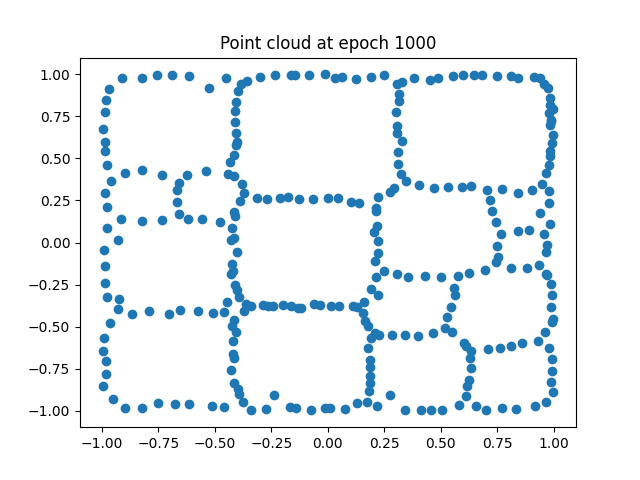

In [13]:
plt.figure()
plt.scatter(model.X.numpy()[:,0], model.X.numpy()[:,1])
plt.title("Point cloud at epoch " + str(epoch))
plt.show()

<IPython.core.display.Javascript object>


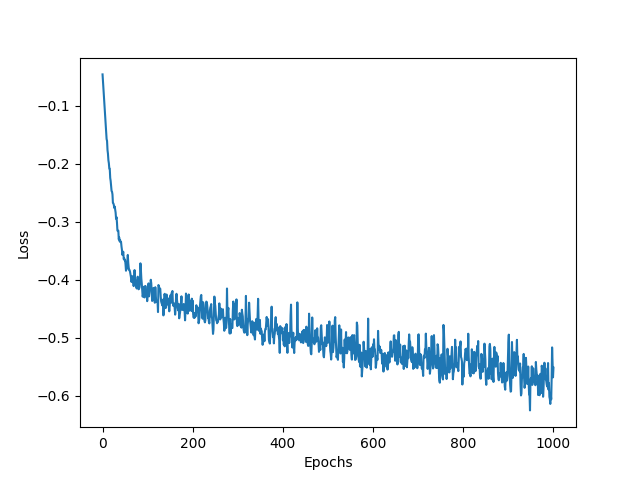

In [14]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

<IPython.core.display.Javascript object>


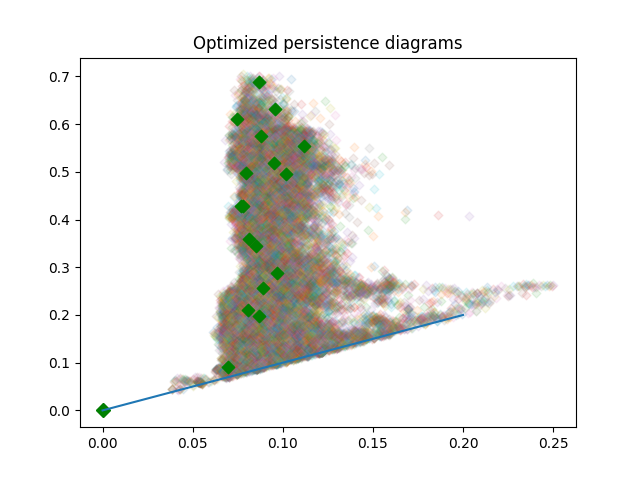

In [15]:
plt.figure()
for dg in dgms[:5:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="green")
plt.plot([-0.,.2], [-0.,.2])
plt.title("Optimized persistence diagrams")
plt.show()

# 2D image application

In the second experiment, we optimize the pixel values of an image so that the artificial noise is removed by minimizing 0-dimensional homology (connected components).

In [16]:
I = np.array(pd.read_csv("data/mnist_test.csv", header=None, sep=","), dtype=np.float32)
idx = np.argwhere(I[:,0] == 8)
image = np.reshape(-I[idx[8],1:], [28,28])
image[2:5,2:5]        -= 20
image[25:27,25:27]    -= 20
image[25:27,2:5]      -= 20
image[1:4,24:26]      -= 20

<IPython.core.display.Javascript object>


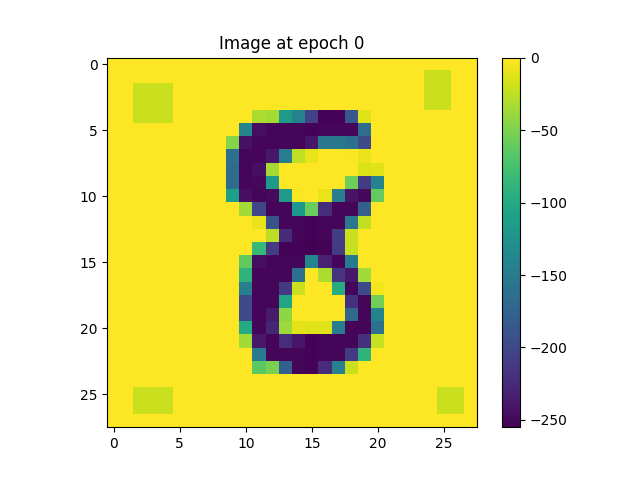

In [17]:
plt.figure()
plt.imshow(image)
plt.title("Image at epoch 0")
plt.colorbar()
plt.show()

In [18]:
X = tf.Variable(initial_value=np.array(image, dtype=np.float32), trainable=True)
model = CubicalModel(X, dim=0, card=100)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1)

In [19]:
losses, dgms, empty = [], [], np.empty([0,2])
for epoch in range(1300+1):
    
    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        dgm = model.call()
        
        # Loss is sum of squared birth coordinates
        loss = tf.math.reduce_sum(tf.abs(dgm[:,1]-dgm[:,0]))
        
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    losses.append(loss.numpy())
    dgms.append(dgm) 

<IPython.core.display.Javascript object>


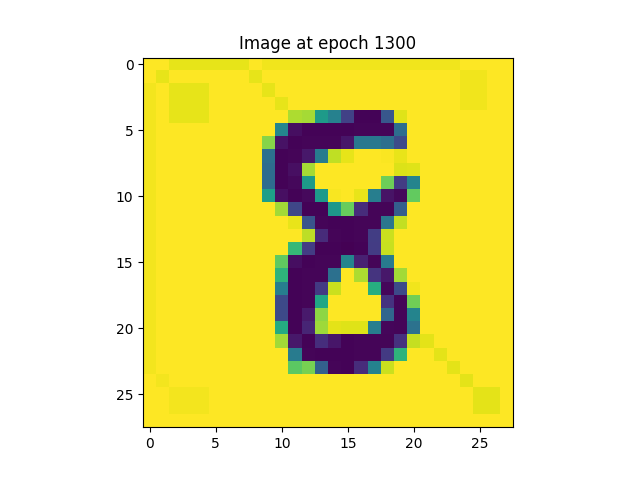

In [20]:
plt.figure()
plt.imshow(model.X.numpy())
plt.title("Image at epoch " + str(epoch))
plt.show()

<IPython.core.display.Javascript object>


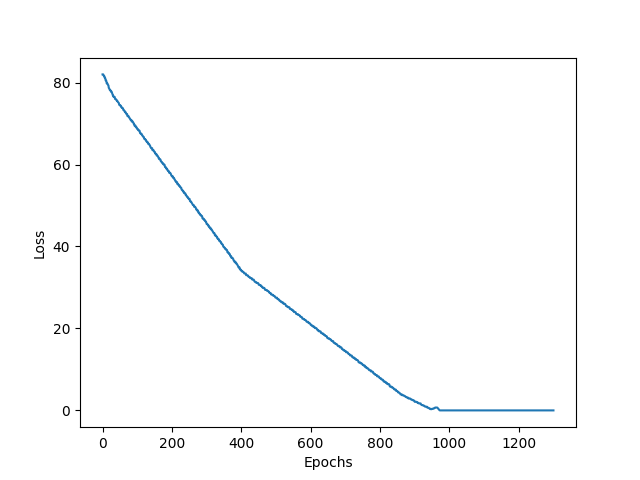

In [21]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

<IPython.core.display.Javascript object>


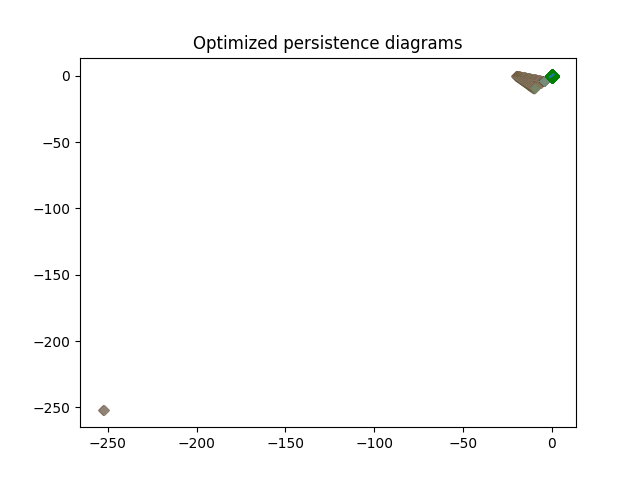

In [22]:
plt.figure()
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="green")
plt.plot([-1,1], [-1,1])
plt.title("Optimized persistence diagrams")
plt.show()

# 3D shape application

In the third experiment, we optimize the vertex filtration values of a 3D shape so that the corresponding persistence diagram matches another constant one (in the Wasserstein distance).

In [41]:
faces, coord = np.loadtxt("data/human_faces", dtype=float)[:,1:], np.loadtxt("data/human_coords", dtype=float)
stbase = gd.SimplexTree()
for i in range(len(faces)):
    stbase.insert(faces[i,:], -1e10)

In [42]:
Finit = coord[:,2]

<IPython.core.display.Javascript object>


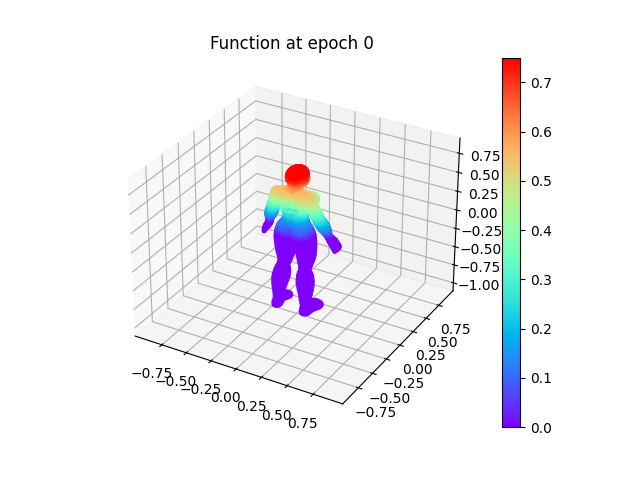

In [43]:
step = 1
fig = plt.figure()
cm = plt.cm.get_cmap("rainbow")
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(coord[::step,0], coord[::step,1], coord[::step,2], c=Finit[::step], s=5, 
                vmin=0, vmax=.75, cmap=cm)
x_limits, y_limits, z_limits = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
x_range, x_middle = abs(x_limits[1] - x_limits[0]), np.mean(x_limits)
y_range, y_middle = abs(y_limits[1] - y_limits[0]), np.mean(y_limits)
z_range, z_middle = abs(z_limits[1] - z_limits[0]), np.mean(z_limits)
plot_radius = 0.5*max([x_range, y_range, z_range])
ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
plt.colorbar(sc)
plt.title("Function at epoch 0")
plt.show()

In [44]:
F = tf.Variable(initial_value=np.array(Finit, dtype=np.float32), trainable=True)
model = SimplexTreeModel(F, dim=0, card=50)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1)

In [45]:
losses, dgms = [], []
for epoch in range(3000+1):
    
    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        dgm = model.call()
    
        # Loss is (squared) Wasserstein distance between the current persistence diagram and the target
        loss = tf.square(wasserstein_distance(dgm, tf.constant(np.array([[-.98,-.03]], dtype=np.float32)), 
                                              order=2, enable_autodiff=True))
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
    losses.append(loss.numpy())
    dgms.append(dgm)

<IPython.core.display.Javascript object>


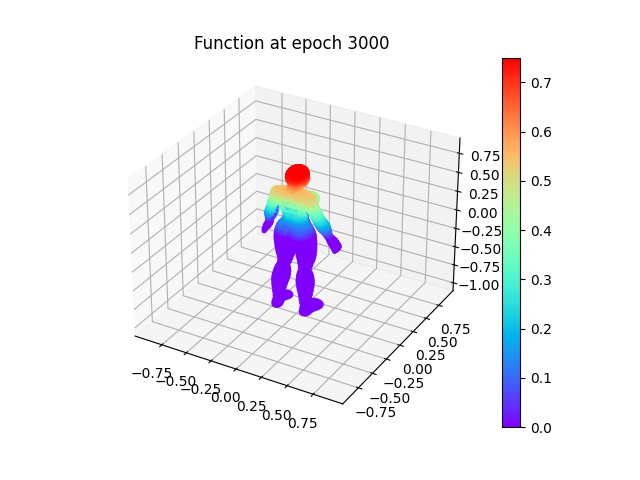

In [51]:
step = 1
fig = plt.figure()
cm = plt.cm.get_cmap("rainbow")
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(coord[::step,0], coord[::step,1], coord[::step,2], c=F.numpy()[::step], s=5, 
                vmin=0, vmax=.75, cmap=cm)
x_limits, y_limits, z_limits = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
x_range, x_middle = abs(x_limits[1] - x_limits[0]), np.mean(x_limits)
y_range, y_middle = abs(y_limits[1] - y_limits[0]), np.mean(y_limits)
z_range, z_middle = abs(z_limits[1] - z_limits[0]), np.mean(z_limits)
plot_radius = 0.5*max([x_range, y_range, z_range])
ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
plt.colorbar(sc)
plt.title("Function at epoch " + str(epoch))
plt.show()

<IPython.core.display.Javascript object>


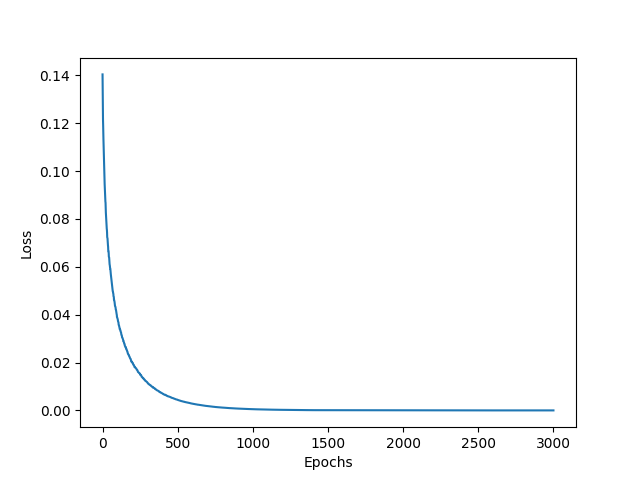

In [50]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [62]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker="D", c="blue")
for dg in dgms[:-1:2]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
plt.plot([-1,1], [-1,1])
plt.title("Optimized persistence diagrams -- zoom 1")
plt.show()

<IPython.core.display.Javascript object>

# Regression application

In the fourth experiment, we optimize the coefficients of a linear regression model so that the persistence diagram of its sublevel sets is empty, except for the three most prominent points.

In [31]:
n, p, alpha, gamma = 500, 100, 1e-6, 1
betastar = np.concatenate([np.linspace(-1.,1.,33) for _ in range(3)] + [[-1.]])
X = np.random.multivariate_normal(mean=np.zeros(shape=[p]), cov=np.eye(p), size=n)
Y = np.matmul(X, betastar) + np.random.normal(0.,.05,n)
X, Y = np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
stbase = gd.SimplexTree()
for i in range(p-1):
    stbase.insert([i,i+1], -1e10)
betainit = np.random.uniform(low=-1., high=1., size=[p])

<IPython.core.display.Javascript object>


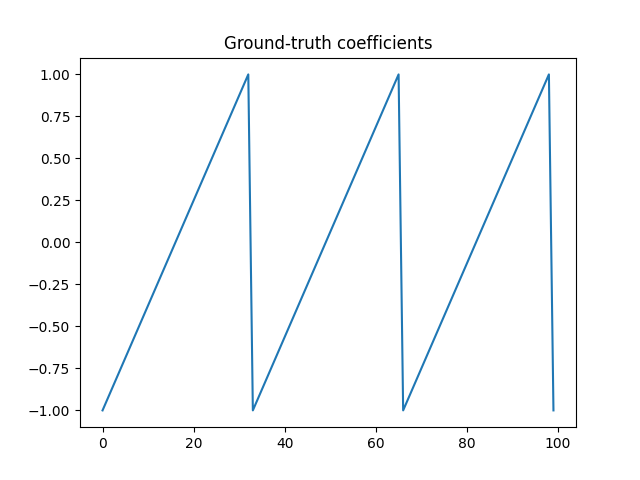

In [32]:
plt.figure()
plt.plot(betastar)
plt.title("Ground-truth coefficients")
plt.show()

<IPython.core.display.Javascript object>


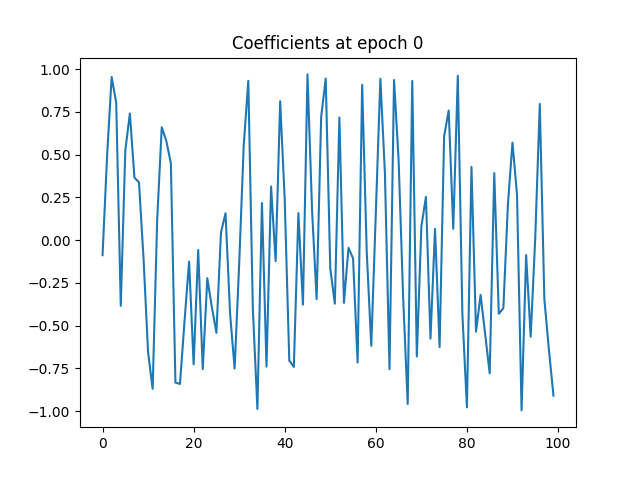

In [33]:
plt.figure()
plt.plot(betainit)
plt.title("Coefficients at epoch 0")
plt.show()

In [34]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
model = SimplexTreeModel(beta, dim=0, card=100)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1)

In [35]:
losses, dgms, betas = [], [], []
for epoch in range(1000+1):
    
    with tf.GradientTape() as tape:
        
        # Compute persistence diagram
        dgm = model.call()
        
        # Loss is MSE plus the total persistence except for the three most prominent points
        loss = alpha * tf.reduce_sum(tf.square(tf.matmul(tf.constant(X), beta) - tf.constant(Y))) \
             + gamma * tf.reduce_sum(tf.abs(dgm[3:,1]-dgm[3:,0]))
        
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    losses.append(loss.numpy())
    dgms.append(dgm)
    betas.append(beta.numpy()[:,0])

<IPython.core.display.Javascript object>


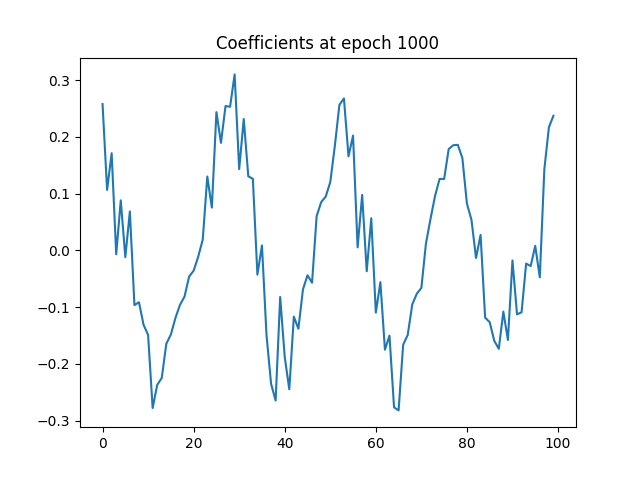

In [36]:
plt.figure()
plt.plot(betas[-1])
plt.title("Coefficients at epoch " + str(epoch))
plt.show()

<IPython.core.display.Javascript object>


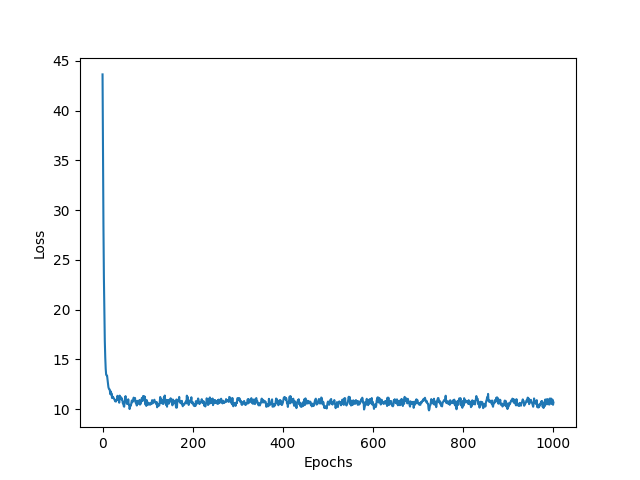

In [37]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

<IPython.core.display.Javascript object>


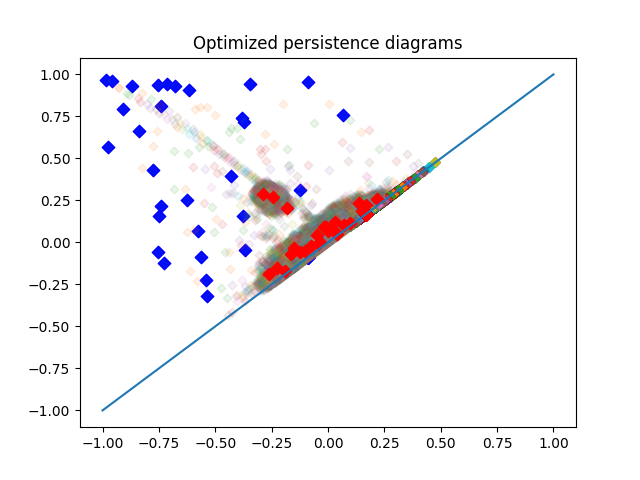

In [40]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker="D", c="blue")
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker="D", alpha=.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker="D", c="red")
plt.plot([-1,1], [-1,1])
plt.title("Optimized persistence diagrams")
plt.show()

In [39]:
print("MSE = " + str(np.square(np.matmul(X,betas[-1]) - Y).sum()))

MSE = 17757.809
